## 2. Collect Evidence

In the second phase of SDMT, we collect _evidence_ to attest to the fact that the model realized the properties specified in the previous phase.

We define and instantiate `Measurement`s to generate this evidence. Each individual piece of evidence is a `Value`. Once `Value`s are produced, we can persist them to an _artifact store_ to maintain our evidence across sessions. 

#### Preliminaries

In [1]:
import os
from pathlib import Path

# The path at which datasets are stored
DATASETS_DIR = Path(os.getcwd()) / "data"
os.makedirs(DATASETS_DIR, exist_ok=True)

# The path at which models are stored
MODELS_DIR = Path(os.getcwd()) / "models"
os.makedirs(MODELS_DIR, exist_ok=True)

# The path at which media is stored
MEDIA_DIR = Path(os.getcwd()) / "media"
os.makedirs(MEDIA_DIR, exist_ok=True)

In [2]:
import pickle
from typing import Tuple

import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import tree

def load_data() -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Load machine learning dataset.
    :return (X_train, X_test, y_train, y_test)
    """
    iris = load_iris(as_frame=True)
    X, y = iris.data, iris.target
    return train_test_split(X, y, test_size=0.2)

def train_model(X_train, y_train):
    """Train a classifier and save."""
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    with (MODELS_DIR / "model_demo.pkl").open("wb") as f:
        pickle.dump(clf, f)

def load_model():
    """Load a trained model."""
    path = MODELS_DIR / "model_demo.pkl"
    with path.open("rb") as f:
        return pickle.load(f)        

In [3]:
# Save the training dataset for use by training procedure
X_train, _, y_train, _ = load_data()
X_train.to_csv(DATASETS_DIR / "data.csv")
y_train.to_csv(DATASETS_DIR / "target.csv")

# Train and save the model.
train_model(X_train, y_train)

#### Initialize MLTE Context

MLTE contains a global context that manages the currently active _session_. Initializing the context tells MLTE how to store all of the artifacts that it produces.

In [4]:
from mlte.session import set_context, set_store

store_path = os.path.join(os.getcwd(), "store")
os.makedirs(store_path, exist_ok=True)

store_path = os.path.join(os.getcwd(), "store")
os.makedirs(store_path, exist_ok=True)   # Ensure we are creating the folder if it is not there.

set_context("ns", "IrisClassifier", "0.0.1")
set_store(f"local://{store_path}")

#### Storage Cost Measurements

This section demonstrates the simplest possible use-case. We import a MLTE-defined `Measurement`, which is then invoked to produce a `Value`. This value can then be inspected and automatically saved to the artifact store.

In [5]:
from mlte.measurement.storage import LocalObjectSize
from mlte.value.types.integer import Integer

# Create a measurement
store_measurement = LocalObjectSize("model size")
# Execute the measurement
size: Integer = store_measurement.evaluate(MODELS_DIR / "model_demo.pkl")

# Inspec values
print(size)

# Save to artifact store
size.save(force=True)

2270


#### Training Cost Measurements

Evidence in this section is largely the same as that demonstrated in the previous section, except it requires some additional setup from the user's perspective. Again, we utilize MLTE-defined `Measurement`s to produce `Value`s that can then be saved to the artifact store.

In [6]:
script = Path.cwd() / "train.py"
args = [
    "--dataset-dir", str(DATASETS_DIR.absolute()),
    "--models-dir", str(MODELS_DIR.absolute())
]

The first evidence we collect are CPU utilization statistics for a local training job.

In [7]:
from mlte.measurement import ProcessMeasurement
from mlte.measurement.cpu import LocalProcessCPUUtilization, CPUStatistics

# Create a measurement
cpu_measurement = LocalProcessCPUUtilization("training cpu")
# Execute the measurement
cpu_stats: CPUStatistics = cpu_measurement.evaluate(ProcessMeasurement.start_script(script, args))

# Inspect values
print(cpu_stats)

# Save to artifact store
cpu_stats.save(force=True)

Average: 2.98%
Minimum: 0.00%
Maximum: 5.95%


Next, we perform a similar procedure to measure the memory consumption of a local training job.

In [8]:
from mlte.measurement.memory import LocalProcessMemoryConsumption, MemoryStatistics

# Create a measurement
mem_measurement = LocalProcessMemoryConsumption("training memory")
# Execute the measurement
mem_stats: MemoryStatistics = mem_measurement.evaluate(ProcessMeasurement.start_script(script, args))

# Inspect values
print(mem_stats)

# Save to artifact store
mem_stats.save(force=True)

Average: 61266
Minimum: 2164
Maximum: 120368


We can also avoid starting the training process twice by using the asynch methods for both measurements. We start the training process once and pass the id to both measurements.

In [9]:
from mlte.measurement import ProcessMeasurement
from mlte.measurement.cpu import LocalProcessCPUUtilization, CPUStatistics
from mlte.measurement.memory import LocalProcessMemoryConsumption, MemoryStatistics

# Create measurements
cpu_measurement = LocalProcessCPUUtilization("training cpu")
mem_measurement = LocalProcessMemoryConsumption("training memory")

# Start the process to measure.
pid = ProcessMeasurement.start_script(script, args)

# Execute the measurements
cpu_measurement.evaluate_async(pid)
mem_measurement.evaluate_async(pid)
cpu_stats: CPUStatistics = cpu_measurement.wait_for_output()
mem_stats: MemoryStatistics = mem_measurement.wait_for_output()

# Inspect values
print(cpu_stats)
print(mem_stats)

# Save to artifact store
cpu_stats.save(force=True)
mem_stats.save(force=True)

Average: 2.96%
Minimum: 0.00%
Maximum: 5.93%
Average: 63448
Minimum: 6528
Maximum: 120368


#### Task Efficacy Measurements

Evidence collected in this section demonstrates MLTE's flexibility in handling inputs from external libraries and in different media types.

In [10]:
# Load the test dataset
_, X_test, _, y_test = load_data()

# Load the model
model = load_model()

# Make predictions
y_pred = model.predict(X_test.to_numpy())

In this first example, we simply wrap the output from `accuracy_score` with a builtin MLTE type (`Real`) to integrate it with our growing collection of evidence.

In [11]:
from sklearn.metrics import accuracy_score

from mlte.value.types.real import Real
from mlte.measurement import ExternalMeasurement

# Evaluate performance
accuracy_measurement = ExternalMeasurement("accuracy", Real, accuracy_score)
accuracy = accuracy_measurement.evaluate(y_test, y_pred)

# Inspect value
print(accuracy)

# Save to artifact store
accuracy.save(force=True)

1.0


In this next example, we define a custom `Result` type to cope with the output of a third-party library that is not supported by a MLTE builtin.

In [12]:
from sklearn.metrics import confusion_matrix
from confusion_matrix import ConfusionMatrix
from mlte.measurement import ExternalMeasurement

# Generate value
matrix_measurement = ExternalMeasurement("confusion matrix", ConfusionMatrix, confusion_matrix)
matrix = matrix_measurement.evaluate(y_test, y_pred)

# Inspect
print(matrix)

# Save to artifact store
matrix.save(force=True)

[[12  0  0]
 [ 0 11  0]
 [ 0  0  7]]


In this final example, we demonstrate the ability to integrate other forms of media in our evidence collection process.

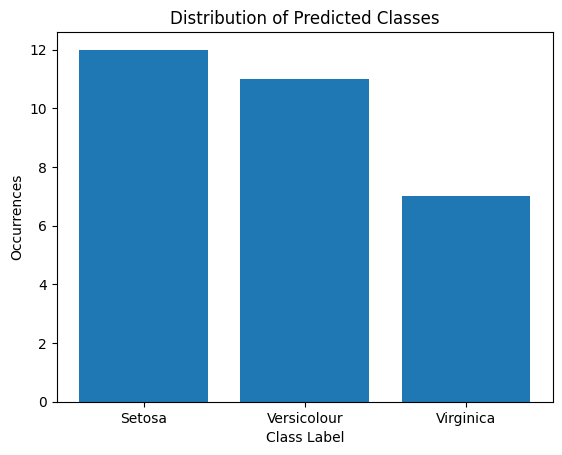

In [13]:
import matplotlib.pyplot as plt

from mlte.measurement import ExternalMeasurement
from mlte.value.types.image import Image

x = ["Setosa", "Versicolour", "Virginica"]
y = [sum(1 for value in y_pred if value == target) for target in [0, 1, 2]]

plt.bar(x, y)
plt.title("Distribution of Predicted Classes")
plt.xlabel("Class Label")
plt.xticks([0, 1, 2])
plt.ylabel("Occurrences")
plt.savefig(MEDIA_DIR / "classes.png")

img_collector = ExternalMeasurement("class distribution", Image)
img = img_collector.ingest(MEDIA_DIR / "classes.png")

img.save(force=True)